**Conditional GAN**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
torch.manual_seed(1)

In [8]:
transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize((0.5),(0.5))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
import matplotlib.pyplot as plt
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


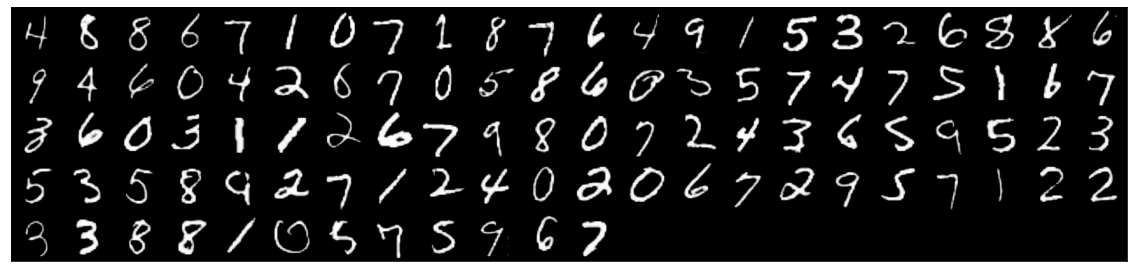

In [10]:
show_batch(trainloader)

In [11]:
import numpy as np
latent_dim = 128
n_classes = 10
embedding_dim = 100
image_shape = (1, 128, 128)
image_dim = int(np.prod(image_shape))


In [12]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
        
    
        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
           

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 1, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, imgs, labels):
        noise_vector, label = imgs, labels
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

a = torch.ones(100,128)
b = torch.ones(100) #1*128 128*8192
b = b.long()
a = a.to(device)
b = b.to(device)
c=generator(a,b)
c.size()

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_s

torch.Size([100, 1, 128, 128])

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
    
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 1*128*128))
             
        self.model = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )
    
    def forward(self, imgs, labels):
        img, label = imgs, labels
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 128, 128)
        concat = torch.cat((img, label_output), dim=1)
        #print(concat.size())
        output = self.model(concat)
        return output

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

a = torch.ones(2,1,128,128)
b = torch.ones(2,1)
b = b.long()
a = a.to(device)
b = b.to(device)
c = discriminator(a,b)
c.size()

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(10, 100)
    (1): Linear(in_features=100, out_features=16384, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)

torch.Size([2, 1])

In [15]:
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, latent_dim=128):
    return Variable(torch.randn(n, latent_dim)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [16]:
def train_discriminator(optimizer, real_data, labels, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data, labels)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data,labels)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, labels, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data, labels)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

In [ ]:
num_epochs = 50
k = 1
test_noise = noise(100)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, labels = data
        labels = labels.to(device)
        # labels = labels.unsqueeze(1).long()
        
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(100),labels).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, labels, fake_data)
        fake_data = generator(noise(100), labels)
        g_error += train_generator(g_optim, labels,fake_data)

    img = generator(test_noise, labels).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

    torch.save({
    'epochs': epoch,
    'generator_model_state_dict': generator.state_dict(),
    'discriminator_model_state_dict': discriminator.state_dict(),
    'g_loss': g_losses,
    'd_loss': d_losses,
    'imgs':images
}, '/content/gdrive/MyDrive/Colab Notebooks/CGAN_model_'+str(epoch)+'.pt')
    
print('Training Finished')
# torch.save(generator.state_dict(), 'mnist_generatorCGAN.pth')



Epoch 0: g_loss: 5.30047607 d_loss: 0.23909447
Epoch 1: g_loss: 3.45165038 d_loss: 0.47635075
Epoch 2: g_loss: 3.23940587 d_loss: 0.54452598
Epoch 3: g_loss: 2.69065237 d_loss: 0.78836745
Epoch 4: g_loss: 2.96440363 d_loss: 0.70366150
Epoch 5: g_loss: 2.55669427 d_loss: 0.89576489
Epoch 6: g_loss: 3.19746065 d_loss: 0.57356185
Epoch 7: g_loss: 2.94065475 d_loss: 0.64271426
Epoch 8: g_loss: 3.16379547 d_loss: 0.59507293
Epoch 9: g_loss: 3.19329762 d_loss: 0.61400539
Epoch 10: g_loss: 3.44486761 d_loss: 0.49258900
Epoch 11: g_loss: 3.51329160 d_loss: 0.53871912
Epoch 12: g_loss: 3.67040300 d_loss: 0.44987994
Epoch 13: g_loss: 4.05707693 d_loss: 0.34448981
Epoch 14: g_loss: 4.60502005 d_loss: 0.29778311
Epoch 15: g_loss: 4.38902998 d_loss: 0.29840985
Epoch 16: g_loss: 5.07968569 d_loss: 0.24092121
Epoch 17: g_loss: 5.11813021 d_loss: 0.23036578
Epoch 18: g_loss: 5.68930054 d_loss: 0.24449438
Epoch 19: g_loss: 5.32327414 d_loss: 0.19765900


In [ ]:
num_epochs = 50
k = 1
test_noise = noise(100)

generator.train()
discriminator.train()
for epoch in range(20,num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, labels = data
        labels = labels.to(device)
        # labels = labels.unsqueeze(1).long()
        
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(100),labels).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, labels, fake_data)
        fake_data = generator(noise(100), labels)
        g_error += train_generator(g_optim, labels,fake_data)

    img = generator(test_noise, labels).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

    torch.save({
    'epochs': epoch,
    'generator_model_state_dict': generator.state_dict(),
    'discriminator_model_state_dict': discriminator.state_dict(),
    'g_loss': g_losses,
    'd_loss': d_losses,
    'imgs':images
}, '/content/gdrive/MyDrive/Colab Notebooks/CGAN_model_'+str(epoch)+'.pt')
    
print('Training Finished')
# torch.save(generator.state_dict(), 'mnist_generatorCGAN.pth')



In [35]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

checkpoint = torch.load('/content/gdrive/MyDrive/Colab Notebooks/CGAN_model_19.pt', map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['generator_model_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_model_state_dict'])

g_losses = checkpoint['g_loss']
d_losses = checkpoint['d_loss']

images = checkpoint['imgs']

In [21]:
# print(generator.state_dict())
# print(discriminator.state_dict())

In [25]:
#saving progress image
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progressCGAN.gif', imgs)

In [26]:
#converting to tensor
print(type(g_losses))
g_losses_T = torch.tensor(g_losses)
print(type(g_losses_T))

print(type(d_losses))
d_losses_T = torch.tensor(d_losses)
print(type(d_losses_T))

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


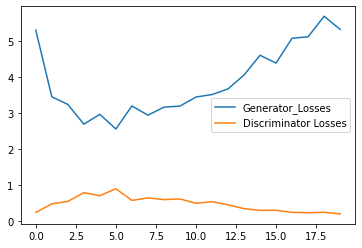

In [28]:
#plotting loss
plt.plot(g_losses_T, label='Generator_Losses')
plt.plot(d_losses_T, label='Discriminator Losses')
plt.legend()
plt.savefig('lossCGAN.png')

In [29]:
#printing loss values
print(g_losses[0])
print(g_losses[-1])

print(d_losses[0])
print(d_losses[-1])

tensor(5.3005, requires_grad=True)
tensor(5.3233, requires_grad=True)
tensor(0.2391, requires_grad=True)
tensor(0.1977, requires_grad=True)


In [30]:
#torch.Size([100, 1, 128, 128]) torch.Size([100])

In [31]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
from matplotlib import gridspec

def dupnoise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)
    
# randomly generated, new latent vectors
sample_size=100
rand_z = dupnoise(sample_size)
generator.eval()# eval mode
# print(rand_z.size())

# a = torch.ones(100,128)
# b = torch.ones(100) #1*128 128*8192

output = None
for label in range(10):
    labels = torch.ones(100) * label
    labels = labels.to(device)
    labels = labels.unsqueeze(1).long()
    # print(labels.size())
    predictions = generator(rand_z, labels)
    predictions = predictions.permute(0,2,3,1)
    pred = predictions.detach().cpu()
    if output is None:
        output = pred
    else:
        output = np.concatenate((output,pred))

In [32]:
print(output.shape)

(1000, 128, 128, 1)


In [33]:
# helper function for viewing a list of passed in sample images
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        # img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((128,128)), cmap='Greys_r')

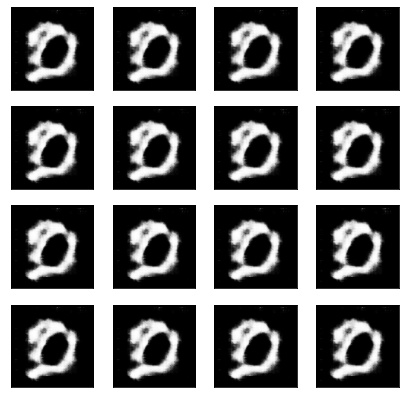

In [34]:
view_samples(output)